# WG Gesucht Stats
> last updated 17.08.2025

Some statistics about the market in Berlin.

In [1]:
import logging
import sys

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import geopandas as gpd

from wggesuchtstats.scraper import find_shared_flats
from wggesuchtstats.models import to_csv


logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

load_dotenv()

True

## Get the data

In [ ]:
flat_ads = find_shared_flats()
to_csv(flat_ads, "data/flat_ads.csv")
len(flat_ads)

## Clean it

In [ ]:
# Load CSV
df = pd.read_csv("../data/flat_ads.csv")
df.head()

,url,published,rent,size,district,female_inhabitants,male_inhabitants,diverse_inhabitants,total_inhabitants
0,wg-zimmer-in-Berlin-Prenzlauer-Berg.6103697.html,2025-08-16T00:00:00,550,16,Prenzlauer Berg,1,0,0,2
1,wg-zimmer-in-Berlin-Prenzlauer-Berg.9961003.html,2025-08-16T00:00:00,999,20,Prenzlauer Berg,1,1,0,4
2,wg-zimmer-in-Berlin-Prenzlauer-Berg.12248079.html,2025-08-16T00:00:00,650,20,Prenzlauer Berg,0,1,0,2
3,wg-zimmer-in-Berlin-Friedrichshain.12230915.html,2025-08-15T00:00:00,750,16,Friedrichshain,0,1,0,2
4,wg-zimmer-in-Berlin-Kreuzberg.12158342.html,2025-07-14T00:00:00,900,20,Kreuzberg,1,0,0,2


## Data Time Range

In [104]:
# ensure datetime
df["published"] = pd.to_datetime(df["published"])

monthly_counts = (
    df.groupby(df["published"].dt.to_period("M"))
      .size()
      .reset_index(name="count")
      .sort_values("published")   # sort Periods
)

# convert Period to timestamp AFTER sorting
monthly_counts["published"] = monthly_counts["published"].dt.to_timestamp()

monthly_counts

,published,count
0,2024-06-01,1
1,2024-12-01,1
2,2025-01-01,1
3,2025-02-01,3
4,2025-03-01,7
5,2025-04-01,9
6,2025-05-01,31
7,2025-06-01,116
8,2025-07-01,1048
9,2025-08-01,2549


## Rents

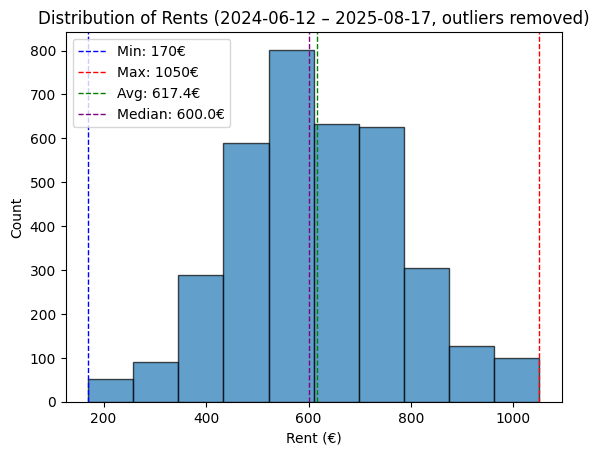

In [27]:
# Define helper to filter outliers in rent
def filter_outliers(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series[(series >= lower) & (series <= upper)]

# Apply filter just for rent histogram
rent_filtered = filter_outliers(df["rent"])

# Recompute stats
time_min = pd.to_datetime(df["published"]).min().date()
time_max = pd.to_datetime(df["published"]).max().date()
min_rent = rent_filtered.min()
max_rent = rent_filtered.max()
avg_rent = rent_filtered.mean()
median_rent = rent_filtered.median()

# Plot histogram
plt.hist(rent_filtered, bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Rent (€)")
plt.ylabel("Count")
plt.title(f"Distribution of Rents ({time_min} – {time_max}, outliers removed)")

# Add lines for stats
plt.axvline(min_rent, color="blue", linestyle="dashed", linewidth=1, label=f"Min: {min_rent:.0f}€")
plt.axvline(max_rent, color="red", linestyle="dashed", linewidth=1, label=f"Max: {max_rent:.0f}€")
plt.axvline(avg_rent, color="green", linestyle="dashed", linewidth=1, label=f"Avg: {avg_rent:.1f}€")
plt.axvline(median_rent, color="purple", linestyle="dashed", linewidth=1, label=f"Median: {median_rent:.1f}€")

plt.legend()
plt.show()


## Sizes

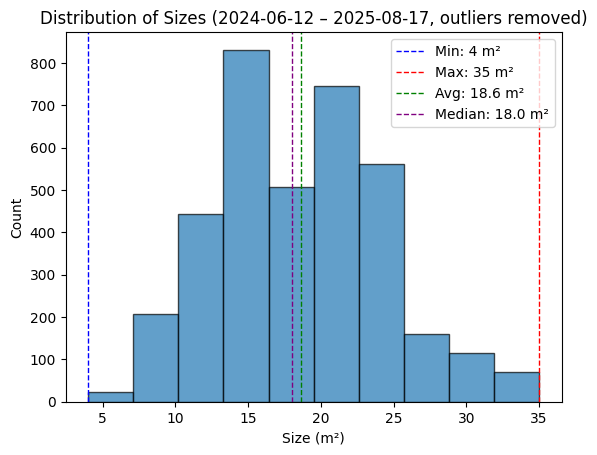

In [29]:
size_filtered = filter_outliers(df["size"])

# Calculate stats for size
min_size = size_filtered.min()
max_size = size_filtered.max()
avg_size = size_filtered.mean()
median_size = size_filtered.median()

# Plot histogram for sizes
plt.hist(size_filtered, bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Size (m²)")
plt.ylabel("Count")
plt.title(f"Distribution of Sizes ({time_min} – {time_max}, outliers removed)")

# Add lines for stats
plt.axvline(min_size, color="blue", linestyle="dashed", linewidth=1, label=f"Min: {min_size:.0f} m²")
plt.axvline(max_size, color="red", linestyle="dashed", linewidth=1, label=f"Max: {max_size:.0f} m²")
plt.axvline(avg_size, color="green", linestyle="dashed", linewidth=1, label=f"Avg: {avg_size:.1f} m²")
plt.axvline(median_size, color="purple", linestyle="dashed", linewidth=1, label=f"Median: {median_size:.1f} m²")

plt.legend()
plt.show()

## Inhabitants

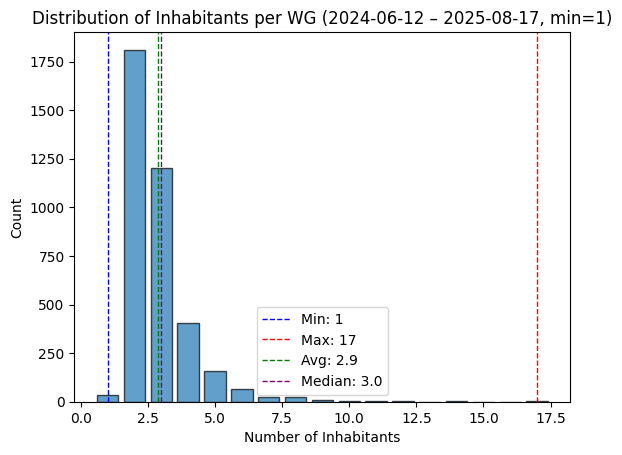

In [35]:
# Minimum inhabitants to consider
min_inh_allowed = 1

inh_filtered = df["total_inhabitants"][df["total_inhabitants"] >= min_inh_allowed]

# Calculate stats
min_inh = inh_filtered.min()
max_inh = inh_filtered.max()
avg_inh = inh_filtered.mean()
median_inh = inh_filtered.median()

# Plot histogram
plt.hist(
    inh_filtered,
    bins=range(int(min_inh), int(max_inh) + 2),
    edgecolor="black",
    alpha=0.7,
    align="left",
    rwidth=0.8
)
plt.xlabel("Number of Inhabitants")
plt.ylabel("Count")
plt.title(f"Distribution of Inhabitants per WG ({time_min} – {time_max}, min={min_inh_allowed})")

# Add lines for stats
plt.axvline(min_inh, color="blue", linestyle="dashed", linewidth=1, label=f"Min: {min_inh:.0f}")
plt.axvline(max_inh, color="red", linestyle="dashed", linewidth=1, label=f"Max: {max_inh:.0f}")
plt.axvline(avg_inh, color="green", linestyle="dashed", linewidth=1, label=f"Avg: {avg_inh:.1f}")
plt.axvline(median_inh, color="purple", linestyle="dashed", linewidth=1, label=f"Median: {median_inh:.1f}")

plt.legend()
plt.show()

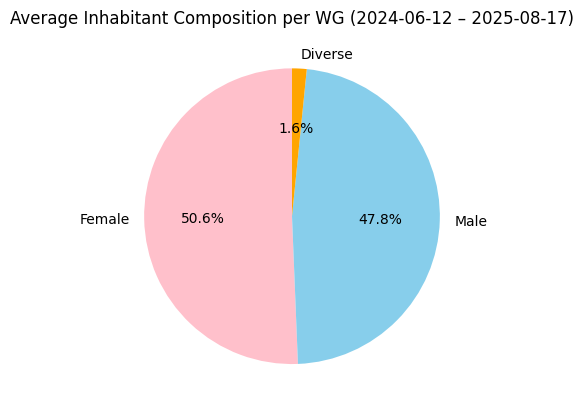

In [36]:
# Compute average composition per ad (normalize per WG)
avg_female = (df["female_inhabitants"] / df["total_inhabitants"]).mean()
avg_male = (df["male_inhabitants"] / df["total_inhabitants"]).mean()
avg_diverse = (df["diverse_inhabitants"] / df["total_inhabitants"]).mean()

# Data for pie chart
avg_composition = [avg_female, avg_male, avg_diverse]
labels = ["Female", "Male", "Diverse"]
colors = ["pink", "skyblue", "orange"]

plt.pie(avg_composition, labels=labels, autopct="%.1f%%", colors=colors, startangle=90)
plt.title(f"Average Inhabitant Composition per WG ({time_min} – {time_max})")
plt.show()

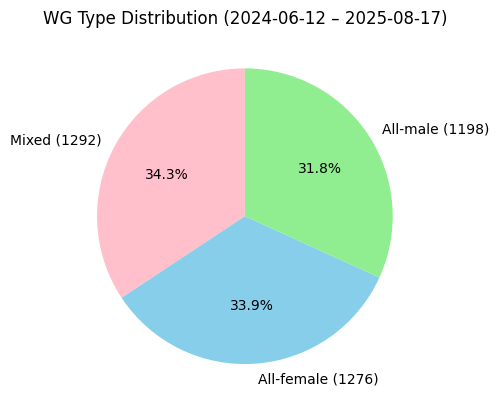

In [37]:
# Categorize ads
def wg_type(row):
    f, m, d = row["female_inhabitants"], row["male_inhabitants"], row["diverse_inhabitants"]
    if f > 0 and m == 0 and d == 0:
        return "All-female"
    elif m > 0 and f == 0 and d == 0:
        return "All-male"
    else:
        return "Mixed"

df["wg_type"] = df.apply(wg_type, axis=1)

# Count ads per category
wg_counts = df["wg_type"].value_counts()

# Pie chart with numbers
labels = [f"{cat} ({count})" for cat, count in wg_counts.items()]
plt.pie(wg_counts, labels=labels, autopct="%.1f%%", startangle=90, colors=["pink","skyblue","lightgreen"])
plt.title(f"WG Type Distribution ({time_min} – {time_max})")
plt.show()

## Districts

In [64]:
district_counts_df = df["district"].value_counts().reset_index()
district_counts_df

,district,count
0,Neukölln,342
1,Prenzlauer Berg,314
2,Friedrichshain,284
3,Kreuzberg,243
4,Mitte,222
...,...,...
202,Alt-Tegel,1
203,Kaulsdorf,1
204,Danzigerstr / Prenzallee,1
205,Rosenthal,1


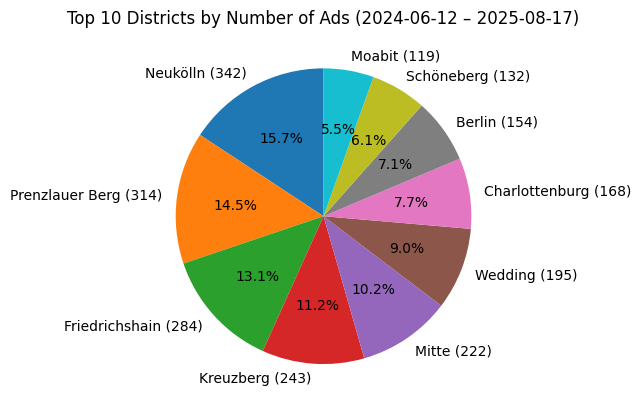

In [65]:
# Take top 10 districts by count
top10_districts = district_counts_df.head(10).set_index("district")["count"]
# Pie chart with counts included in labels
top10_labels = [f"{district} ({count})" for district, count in top10_districts.items()]

plt.pie(
    top10_districts,
    labels=top10_labels,
    autopct="%.1f%%",
    startangle=90
)
plt.title(f"Top 10 Districts by Number of Ads ({time_min} – {time_max})")
plt.show()

## Spatial/District Analysis

In [42]:
gdf = gpd.read_file("data/berlin_ortsteile.geojson")
print(gdf.columns)
print(gdf.head())

Index(['gml_id', 'spatial_name', 'spatial_alias', 'spatial_type', 'OTEIL',
       'BEZIRK', 'FLAECHE_HA', 'geometry'],
      dtype='object')
             gml_id spatial_name spatial_alias spatial_type         OTEIL  \
0  re_ortsteil.0101         0101         Mitte      Polygon         Mitte   
1  re_ortsteil.0102         0102        Moabit      Polygon        Moabit   
2  re_ortsteil.0103         0103  Hansaviertel      Polygon  Hansaviertel   
3  re_ortsteil.0104         0104    Tiergarten      Polygon    Tiergarten   
4  re_ortsteil.0105         0105       Wedding      Polygon       Wedding   

  BEZIRK  FLAECHE_HA                                           geometry  
0  Mitte   1063.8748  POLYGON ((13.41649 52.52696, 13.41635 52.52702...  
1  Mitte    768.7909  POLYGON ((13.33884 52.51974, 13.33884 52.51974...  
2  Mitte     52.5337  POLYGON ((13.34322 52.51557, 13.34323 52.51557...  
3  Mitte    516.0672  POLYGON ((13.36879 52.49878, 13.36891 52.49877...  
4  Mitte    919.9112  POLY

In [48]:
unique_ortsteile = gdf["OTEIL"].unique()
unique_ortsteile.sort()

df_unique_ortsteile = pd.DataFrame(unique_ortsteile, columns=["Ortsteil"])
df_unique_ortsteile

,Ortsteil
0,Adlershof
1,Alt-Hohenschönhausen
2,Alt-Treptow
3,Altglienicke
4,Baumschulenweg
...,...
91,Wilhelmsruh
92,Wilhelmstadt
93,Wilmersdorf
94,Wittenau


In [92]:
# Just the non-specific "Berlin" Ortsteil is not included ofc
top_districts = set(district_counts_df.head(20)["district"].tolist())
not_in_ortsteile = top_districts - set(unique_ortsteile.tolist())
not_in_ortsteile

{'Berlin',
 'Charlottenburg-Wilmersdorf',
 'Friedrichshain-Kreuzberg',
 'Tempelhof-Schöneberg'}

In [93]:
districts_to_visualize = top_districts - not_in_ortsteile
districts_to_visualize

{'Charlottenburg',
 'Friedrichshain',
 'Kreuzberg',
 'Lichtenberg',
 'Mitte',
 'Moabit',
 'Neukölln',
 'Pankow',
 'Prenzlauer Berg',
 'Reinickendorf',
 'Schöneberg',
 'Spandau',
 'Steglitz',
 'Tempelhof',
 'Wedding',
 'Wilmersdorf'}

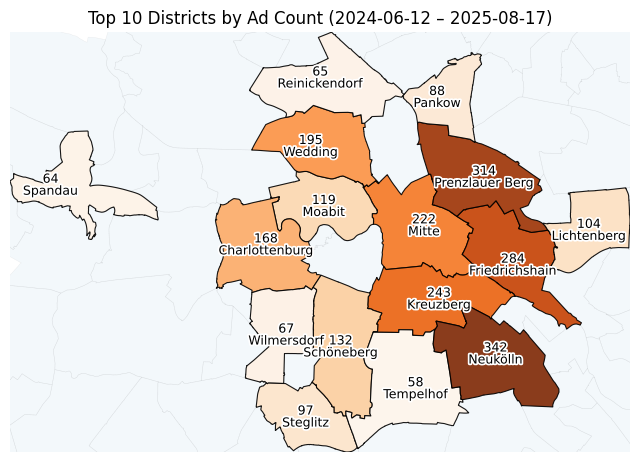

In [ ]:
# keep only top-x to show
top10 = district_counts_df[district_counts_df["district"].isin(districts_to_visualize)]

# merge counts onto geometries
gdf_top = gdf.merge(top10, left_on="OTEIL", right_on="district", how="inner")

# nice, consistent light→strong coloring
vmin, vmax = gdf_top["count"].min(), gdf_top["count"].max()

# background
ax = gdf.plot(edgecolor="black", linewidth=0.4, alpha=0.05, figsize=(8, 8))

# choropleth (no legend), consistent cmap range
gdf_top.plot(
    ax=ax,
    column="count",
    cmap="Oranges",
    vmin=vmin,
    vmax=vmax,
    edgecolor="black",
    linewidth=0.8,
    alpha=0.9,
)

# labels (count + name) with white stroke for readability
for _, r in gdf_top.iterrows():
    x, y = r.geometry.representative_point().coords[0]
    ax.text(
        x, y, f"{int(r['count'])}\n{r['OTEIL']}",
        ha="center", va="center", fontsize=9, linespacing=0.9,
        path_effects=[pe.withStroke(linewidth=2.5, foreground="white")]
    )

# zoom to selected
xmin, ymin, xmax, ymax = gdf_top.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

ax.set_title(f"Top Districts by Ad Count ({time_min} – {time_max})")
ax.axis("off")
plt.show()

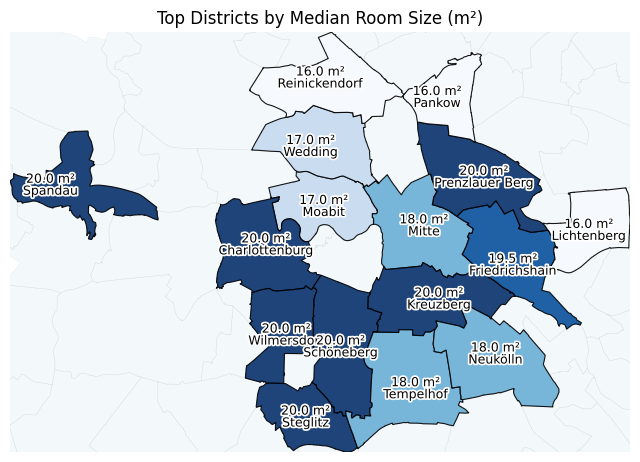

In [98]:
# avg size per district
avg_size_df = (
    df.groupby("district", as_index=False)["size"]
      .median()
      .rename(columns={"size": "avg_sqm"})
)

# keep only top-10 to show
top10_avg = avg_size_df[avg_size_df["district"].isin(districts_to_visualize)]

# merge onto geometries
gdf_avg = gdf.merge(top10_avg, left_on="OTEIL", right_on="district", how="inner")

# consistent light→strong color scale
vmin, vmax = gdf_avg["avg_sqm"].min(), gdf_avg["avg_sqm"].max()

# background
ax = gdf.plot(edgecolor="black", linewidth=0.4, alpha=0.05, figsize=(8, 8))

# choropleth (no legend)
gdf_avg.plot(
    ax=ax,
    column="avg_sqm",
    cmap="Blues",
    vmin=vmin,
    vmax=vmax,
    edgecolor="black",
    linewidth=0.8,
    alpha=0.9,
)

# labels: avg m² + name
for _, r in gdf_avg.iterrows():
    x, y = r.geometry.representative_point().coords[0]
    ax.text(
        x, y, f"{r['avg_sqm']:.1f} m²\n{r['OTEIL']}",
        ha="center", va="center", fontsize=9, linespacing=0.9,
        path_effects=[pe.withStroke(linewidth=2.5, foreground="white")]
    )

# zoom to selected
xmin, ymin, xmax, ymax = gdf_avg.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

ax.set_title("Top Districts by Median Room Size (m²)")
ax.axis("off")
plt.show()

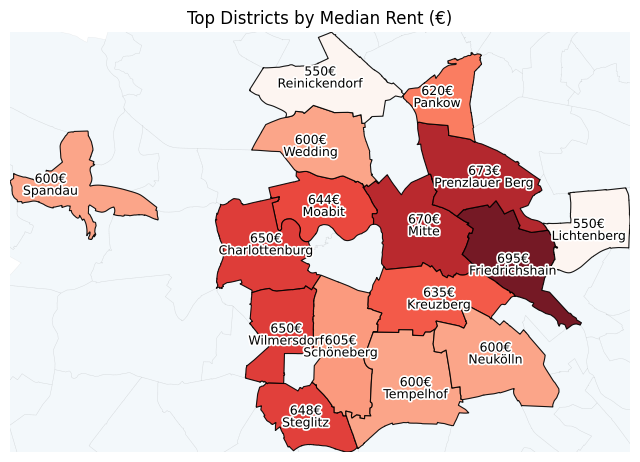

In [97]:
avg_rent_df = (
    df.groupby("district", as_index=False)["rent"]
      .median()
      .rename(columns={"rent": "avg_rent"})
)

top10_avg_rent = avg_rent_df[avg_rent_df["district"].isin(districts_to_visualize)]
gdf_avg_rent = gdf.merge(top10_avg_rent, left_on="OTEIL", right_on="district", how="inner")

vmin, vmax = gdf_avg_rent["avg_rent"].min(), gdf_avg_rent["avg_rent"].max()

ax = gdf.plot(edgecolor="black", linewidth=0.4, alpha=0.05, figsize=(8, 8))
gdf_avg_rent.plot(
    ax=ax, column="avg_rent", cmap="Reds", vmin=vmin, vmax=vmax,
    edgecolor="black", linewidth=0.8, alpha=0.9
)

for _, r in gdf_avg_rent.iterrows():
    x, y = r.geometry.representative_point().coords[0]
    ax.text(
        x, y, f"{r['avg_rent']:.0f}€\n{r['OTEIL']}",
        ha="center", va="center", fontsize=9, linespacing=0.9,
        path_effects=[pe.withStroke(linewidth=2.5, foreground="white")]
    )

xmin, ymin, xmax, ymax = gdf_avg_rent.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
ax.set_title("Top Districts by Median Rent (€)")
ax.axis("off")
plt.show()